this is a notebook for speech siamese. 
the goal is to add siamese network after the speech command network to make a one-shot speech command model. with this model, take two piece of audio as input, the model will tell if it is the same speech command or not. 
if the accuracy is good enough, we make take it input product for voice trigger or voice command which are useful for all kind of product. 

the trick may be if siamese can make one shot accure enough. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import hashlib
import math, time, datetime
import os.path
import random
import re
import sys
import tarfile

#print(sys.executable)
import matplotlib.pyplot as plt
import numpy as np
import librosa as rosa
import librosa.display
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda, BatchNormalization, Activation, LSTM, GRU
#from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
#from tensorflow.python.ops import io_ops
#from tensorflow.python.platform import gfile
#from tensorflow.python.util import compat

default_number_of_mfcc=128
default_sample_rate=16000
default_hop_length=512 
default_wav_duration=1 # 1 second
default_train_samples=10000
default_test_samples=100
default_epochs=10
default_batch_size=256
default_wanted_words=["one", "two", "bed", "backward", "bird", "cat", "dog", "eight", "five", "follow", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero","up"]
#for mac
#speech_data_dir="/Users/hermitwang/Downloads/speech_dataset"
#default_model_path="/Users/hermitwang/Downloads/pretrained/speech_siamese"
#for ubuntu
#speech_data_dir="/home/hermitwang/TrainingData/datasets/speech_dataset"
#default_model_path="/home/hermitwang/TrainingData/pretrained/speech_siamese"
#for windows of work
#speech_data_dir="D:\\HermitWang\\DeepLearning\\dataset\\speech_dataset"
#default_model_path="D:\\HermitWang\\DeepLearning\\dataset\\trained\\siamese"
#for himl 
speech_data_dir="/home/hermitwang/Projects/datasets/speech_dataset"
default_model_path="/home/hermitwang/Projects/pretrained/speech_siamese"


# One shot keyword trigger


Here is another implementation of one-shot learning of keyword trigger with librosa mfcc. 
librosa cannot put into tensorflow graph. so mfcc computation will be done before conv network. 
that means load_wav_mfcc has to convert all wav file to mfcc vector. 
Here i have to understand
    1, what is the good mfcc vector dimension. 20, 127 may not be the right input for conv network. 
    2, even the mfcc output of librosa is not the same as tensorflow contrib.decode wav, it is enough if it has all audio feature. put librosa mfcc output as input of conv net, it will do good learning about feature abstraction. 
    3, conv net may not be that difficult. just like conv2d -> maxpooling -> conv2d->flatten->dense with softmax. 
    4, build the train network with librosa and conv net.
    5, take the dense vector output as feature extractor. 
    6, build siamese network with the feature extractor. 
    7, may add couples of dense layer to learn the feature mapping and comparation of siamese. 
    8, if that works, we get an one-shot learning for key word trigger...
    9, in reality, we still have to work out how to split the audio stream into audio clip as the input the librosa mfcc.
    

### MFCC 

extract MFCC from wav file
what is the wav parameter for MFCC output

tensorflow speech command parameter 
{'desired_samples': 16000, 'window_size_samples': 480, 'window_stride_samples': 160, 'spectrogram_length': 98, 'fingerprint_width': 40, 'fingerprint_size': 3920, 'label_count': 12, 'sample_rate': 16000, 'preprocess': 'mfcc', 'average_window_width': -1}

Mel-frequency cepstral coefficients (MFCCs)
Parameters:	
y:np.ndarray [shape=(n,)] or None
audio time series
sr:number > 0 [scalar]
sampling rate of y
S:np.ndarray [shape=(d, t)] or None
log-power Mel spectrogram
n_mfcc: int > 0 [scalar]
number of MFCCs to return
Returns:	
M:np.ndarray [shape=(n_mfcc, t)]
MFCC sequence

need more study about MFCC output


## How to calculate the lenght of mfcc vector
Short Answer

You can specify the change the length by changing the parameters used in the stft calculations. The following code will double the size of your output (20 x 113658)

data = librosa.feature.mfcc(y=y, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)
Long Answer

Librosa's librosa.feature.mfcc() function really just acts as a wrapper to librosa's librosa.feature.melspectrogram() function (which is a wrapper to librosa.core.stft and librosa.filters.mel functions).

All of the parameters pertaining to segementation of the audio signal - namely the frame and overlap values - are specified utilized in the Mel-scaled power spectrogram function (with other tune-able parameters specified for nested core functions). You specify these parameters as keyword arguments in the librosa.feature.mfcc() function.

All extra **kwargs parameters are fed to librosa.feature.melspectrogram() and subsequently to librosa.filters.mel()

By Default, the Mel-scaled power spectrogram window and hop length are the following:

n_fft=2048

hop_length=512

So assuming you used the default sample rate (sr=22050), the output of your mfcc function makes sense:

output length = (seconds) * (sample rate) / (hop_length)

(1319) * (22050) / (512) = 56804 samples


the mfcc vector size is 128 * 32   

1 * 16000/512 = 31.25 = 32 

(32, 128)
(32, 128)


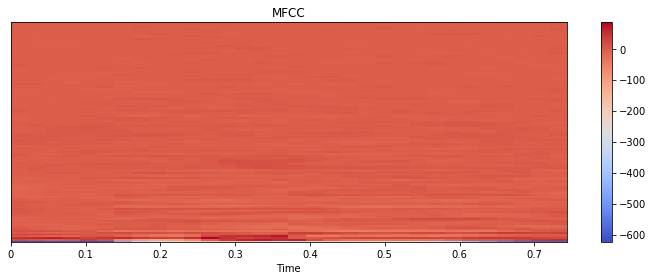

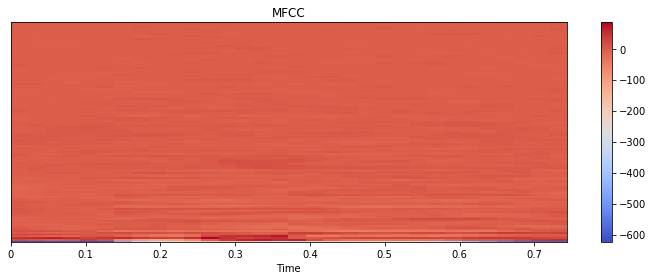

In [2]:
def load_wav_mfcc(filename):
    wav_loader, sample_rate = rosa.load(filename, sr=default_sample_rate)
    #print(rosa.get_duration(wav_loader, sample_rate))
    wav_mfcc = rosa.feature.mfcc(y=wav_loader, sr=default_sample_rate, n_mfcc=default_number_of_mfcc)
    wav_mfcc = np.transpose(wav_mfcc)
    return wav_mfcc

def get_default_mfcc_length(default_wav_duration=1):
    length = int(math.ceil(default_wav_duration * default_sample_rate / default_hop_length))
    return length

def mfcc_display(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
wav_mfcc_data = load_wav_mfcc(speech_data_dir + "/six/ffd2ba2f_nohash_3.wav")
print(wav_mfcc_data.shape)
mfcc_display(np.transpose(wav_mfcc_data))

wav_mfcc_data = load_wav_mfcc(speech_data_dir + "/six/ffd2ba2f_nohash_3.wav") #""/five/56eab10e_nohash_0.wav")
print(wav_mfcc_data.shape)
mfcc_display(np.transpose(wav_mfcc_data))

# Wav MFCC loader
Wav file loader and export mfcc sequence. 

0, go throught all wav file to add background voice into command wav file
1, go through all wav file and convert to MFCC sequence
2, construct pair of MFCC sequence and a target (0 or 1, 0 for different command, 1 for the same command)
    the same word * 1000, random generate key index, the first index of wav, and the second index of wav. 
    the diff word * 1000, random generae two key index, the first index of wav, and the second index of wav. 
    the format will be [mfcc 1, mfcc 2, 0/1 for the same or different]
3, prepare pair of MFCC and targets according to batch size.  

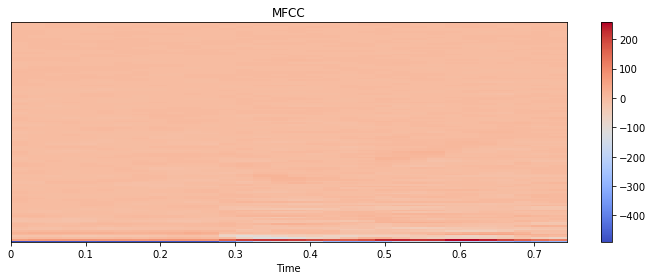

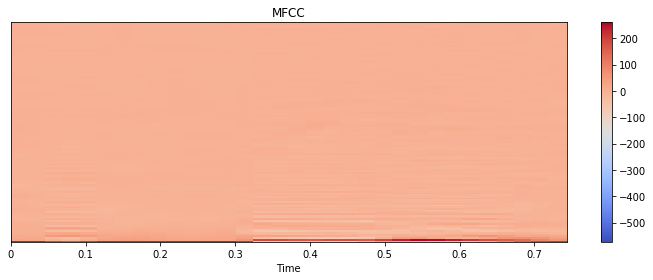

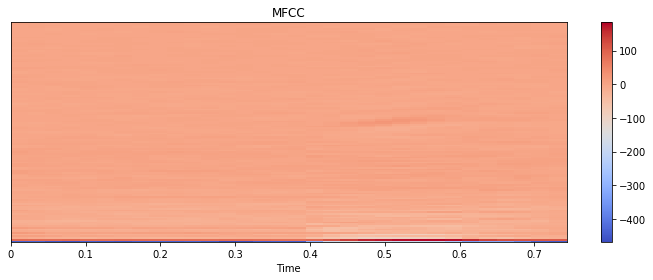

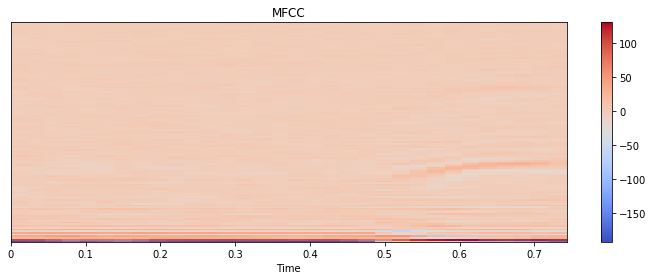

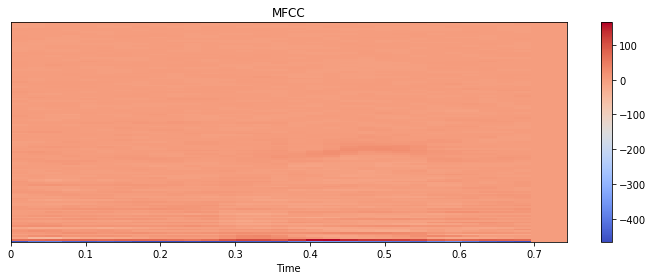

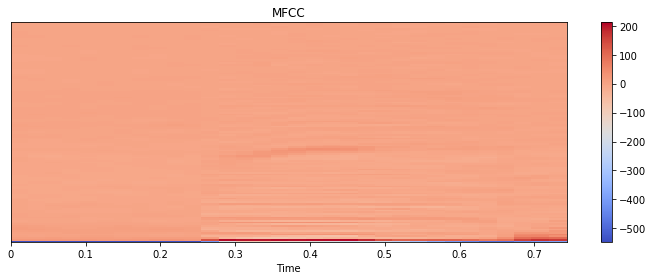

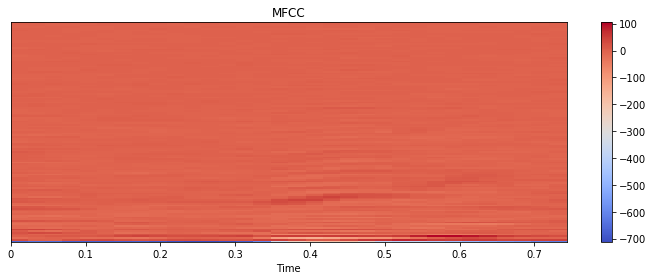

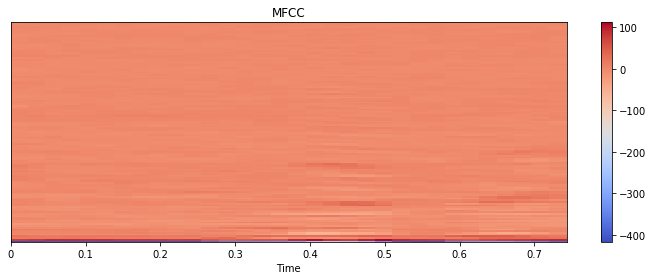

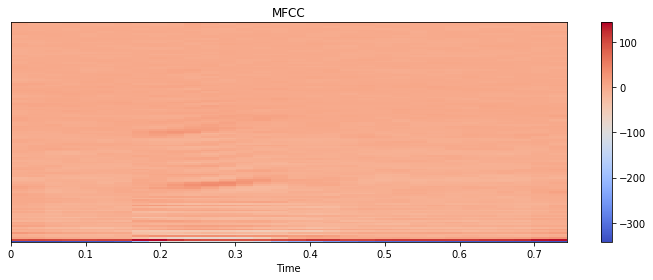

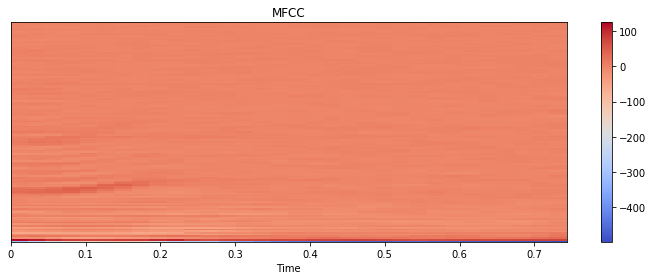

In [3]:
class WavMFCCLoader(object):
    def __init__(self, data_dir, wanted, validation_percentage=0, testing_percentage=0):
        self.data_dir = data_dir
        self.wanted = wanted
        self.default_mfcc_length=get_default_mfcc_length(default_wav_duration)
        self.wav_files = dict()
        self.wav_file_index()
        
    def wav_file_index(self):
        for dirpath, dirnames, files in os.walk(self.data_dir):
            for name in files:
                if name.lower().endswith('.wav'):
                    #for windows
                    #word_name = dirpath.rsplit('\\', 1)[1];
                    #for others
                    word_name = dirpath.rsplit('/', 1)[1];
                    if word_name in self.wanted:
                        file_name = os.path.join(dirpath, name)
                        #print(file_name, dirpath, word_name)
    
                        if word_name in self.wav_files.keys():
                            self.wav_files[word_name].append(file_name)
                        else:
                            self.wav_files[word_name] = [file_name]
                    
        return self.wav_files


    def wavs_to_mfcc_pair(self):
        how_many_words = len(self.wanted)
        a_index = random.randint(0, how_many_words - 1)
        b_index = random.randint(0, how_many_words - 1)
        a_wav_index = b_wav_index = -1
        mfcc_pair = np.array([3, 1])
        if (a_index > b_index):
            a_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(self.wav_files[self.wanted[b_index]]) - 1)
            mfcc_1 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(self.wav_files[self.wanted[b_index]][b_wav_index])
            mfcc_pair = 0            
        else:
            a_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
            mfcc_1 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(self.wav_files[self.wanted[a_index]][b_wav_index])
            mfcc_pair = 1
            
        #print("aaa", mfcc_1.shape, mfcc_2.shape)    
        return mfcc_1, mfcc_2, mfcc_pair
        
    def get_mfcc_pairs(self, how_many):
        mfcc1_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        mfcc2_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        same_data = np.zeros(how_many)
        for i in range(0, how_many - 1):
            
            mfcc1_data_, mfcc2_data_, same_data[i] = self.wavs_to_mfcc_pair()
            mfcc1_data[i, 0:mfcc1_data_.shape[0], : ] = mfcc1_data_
            mfcc2_data[i, 0:mfcc2_data_.shape[0], : ] = mfcc2_data_
            #np.append(mfcc1_data, mfcc1_)
            #np.append(mfcc2_data, mfcc2_)
            #np.append(same_data, same_)          
        #print(mfcc_pairs)
    
        return mfcc1_data, mfcc2_data, same_data
        
loader = WavMFCCLoader(speech_data_dir, wanted=["one", "two", "bed", "backward", "bird", "cat", "dog", "eight", "five", "follow", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero"])
#wav_list = loader.wav_file_index()
mfcc1_data, mfcc2_data, same_pair = loader.get_mfcc_pairs(10)
for i in range( len(same_pair)):
    if (same_pair[i]):
        mfcc_display(np.transpose(mfcc1_data[i]))
        mfcc_display(np.transpose(mfcc2_data[i]))
        

# LSTM Network

create a keras lstm network, take mfcc vector as input.

the speech command mfcc input shape is (?, mfcc_number, hop_number, 1)




In [4]:
def create_lstm_model(local_input_shape, is_training=True):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=local_input_shape))
    model.add(GRU(1024, return_sequences=False, stateful=False, input_shape=local_input_shape))
    #model.add(GRU(256, return_sequences=True, stateful=False))
    #model.add(GRU(256, stateful=False))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation("sigmoid")) 
    #if (is_training):
    #    model.add(Dropout(0.5))
    #model.add(Dense(labels_count, activation="softmax"))
    
    return model


In [8]:
def create_siamese_model(input_shape, siamese_mode = 'concat'):
    right_input = Input(input_shape)
    left_input = Input(input_shape)
    keras_model = create_lstm_model(input_shape)
    
    right_encoder = keras_model(right_input)
    left_encoder = keras_model(left_input)
    if (siamese_mode == 'minus'):
        concatenated_layer = Lambda(lambda x: x[0]-x[1], output_shape=lambda x: x[0])([right_encoder, left_encoder])
    elif (siamese_mode == 'abs'):
        concatenated_layer = Lambda(lambda x: tf.abs(x[0]-x[1]), output_shape=lambda x: x[0])([right_encoder, left_encoder])
    #elif (siamese_mode == "eu"):
    #    concatenated_layer = Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0]-x[1]), 2)), output_shape=lambda x: x[0])([right_encoder, left_encoder])
    else:
        raise ValueError("unknown siamese_mode")
        
    output_layer = Dense(1, activation='sigmoid')(concatenated_layer)
    siamese_model = Model([right_input, left_input], output_layer)
    return siamese_model
    
def siamese_train(local_siamese_mode='abs', train_samples=default_train_samples, wanted_words=default_wanted_words, local_batch_size=default_batch_size):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)
    siamese_model = create_siamese_model((default_mfcc_length, default_number_of_mfcc), siamese_mode=local_siamese_mode)

    siamese_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    loader = WavMFCCLoader(speech_data_dir, wanted=wanted_words)
    mfcc1_data, mfcc2_data, pairs = loader.get_mfcc_pairs(train_samples)
    #mfcc1_data = np.transpose(mfcc1_data)
    #mfcc2_data = np.transpose(mfcc2_data)
    x1_train = mfcc1_data #.reshape((train_samples, default_mfcc_length, default_number_of_mfcc)) #hop length is the time feature
    x2_train = mfcc2_data #.reshape((train_samples, default_mfcc_length, default_number_of_mfcc)) #mfcc_number is the data feature
    y_train = pairs  #keras.utils.to_categorical(pairs, num_classes=1)
    
    
    siamese_model.fit([x1_train, x2_train], y_train, epochs=default_epochs, batch_size=local_batch_size)
    
    
    mfcc1_test, mfcc2_test, pairs_test = loader.get_mfcc_pairs(default_test_samples)
    #mfcc1_test = np.transpose(mfcc1_test)
    #mfcc2_test = np.transpose(mfcc2_test)
    
    x1_test = mfcc1_test #.reshape((default_test_samples, default_mfcc_length, default_number_of_mfcc))
    x2_test = mfcc2_test #.reshape((default_test_samples, default_mfcc_length, default_number_of_mfcc))
    y_test = pairs_test 
    
    loss, accuracy = siamese_model.evaluate([x1_test, x2_test], y_test)    
    
    siamese_model.save(default_model_path+"/speech_siamese.h5")

    print(loss)
    return accuracy

def siamese_test(test_samples=default_test_samples, wanted_words=default_wanted_words):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)
    loader = WavMFCCLoader(speech_data_dir, wanted=wanted_words)
    siamese_model = keras.models.load_model(default_model_path+"/speech_siamese.h5")    
    mfcc1_test, mfcc2_test, pairs_test = loader.get_mfcc_pairs(test_samples)
    x1_test = mfcc1_test #.reshape((test_samples, default_mfcc_length, default_number_of_mfcc))
    x2_test = mfcc2_test #.reshape((test_samples, default_mfcc_length, default_number_of_mfcc))
    y_test = pairs_test 
    
    loss, accuracy = siamese_model.test_on_batch(x=[x1_test, x2_test], y=y_test)
    print(loss)
    return accuracy

Siamese Network

## main 

In [ ]:
#wav_mfcc = load_wav_mfcc("/Users/hermitwang/Downloads/speech_dataset/backward/0a2b400e_nohash_0.wav")
#print(wav_mfcc.shape) 
batch_size_numbers=[32, 64, 128, 256, 512]
for i in range(5):
    for j in range(5):
        print("Train batch size" + str(batch_size_numbers[j]) + " of " + str(i+1) + "0000 run:")
        score=siamese_train(local_siamese_mode='abs', local_batch_size=batch_size_numbers[j], train_samples=(1+i)*10000, wanted_words=["one", "two", "cat", "dog", "bed", "backward", "eight","forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero","up"])
        print(score)
        score=siamese_test(wanted_words=["five", "follow", "bird"])
    
        print(score)

Train batch size32 of 10000 run:
Epoch 1/10
10000/10000 [==============================] - 51s 5ms/step - loss: 0.6747 - acc: 0.5909
Epoch 2/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.6077 - acc: 0.6699
Epoch 3/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.5475 - acc: 0.7214
Epoch 4/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.5103 - acc: 0.7490
Epoch 5/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.4746 - acc: 0.7739
Epoch 6/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.4526 - acc: 0.7864
Epoch 7/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.4179 - acc: 0.8058
Epoch 8/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.3952 - acc: 0.8212
Epoch 9/10
10000/10000 [==============================] - 39s 4ms/step - loss: 0.3543 - acc: 0.8431
Epoch 10/10
100/100 [==============================] - 5s 49ms/step

20000/20000 [==============================] - 31s 2ms/step - loss: 0.4547 - acc: 0.7903
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.4002 - acc: 0.8207
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.3480 - acc: 0.8497
Epoch 6/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.2973 - acc: 0.8759
Epoch 7/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.2593 - acc: 0.8960
Epoch 8/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2154 - acc: 0.9134
Epoch 9/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1815 - acc: 0.9302
Epoch 10/10
100/100 [==============================] - 6s 64ms/step
0.6838260662555694
0.73
1.1187925
0.63
Train batch size256 of 20000 run:
Epoch 1/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.6307 - acc: 0.6445
Epoch 2/10
20000/20000 [==============================] - 30s 1ms/step

30000/30000 [==============================] - 49s 2ms/step - loss: 0.2161 - acc: 0.9213
Epoch 6/10
30000/30000 [==============================] - 49s 2ms/step - loss: 0.1480 - acc: 0.9505
Epoch 7/10
30000/30000 [==============================] - 49s 2ms/step - loss: 0.1031 - acc: 0.9679
Epoch 8/10
30000/30000 [==============================] - 49s 2ms/step - loss: 0.0750 - acc: 0.9777
Epoch 9/10
30000/30000 [==============================] - 49s 2ms/step - loss: 0.0568 - acc: 0.9843
Epoch 10/10
100/100 [==============================] - 8s 82ms/step
0.5552593660354614
0.81
1.0574453
0.61
Train batch size32 of 40000 run:
Epoch 1/10
40000/40000 [==============================] - 476s 12ms/step - loss: 0.6072 - acc: 0.6638
Epoch 2/10
40000/40000 [==============================] - 449s 11ms/step - loss: 0.5250 - acc: 0.7395
Epoch 3/10
40000/40000 [==============================] - 442s 11ms/step - loss: 0.4855 - acc: 0.7674
Epoch 4/10
40000/40000 [==============================] - 442s 11

50000/50000 [==============================] - 308s 6ms/step - loss: 0.3195 - acc: 0.8616
Epoch 8/10
50000/50000 [==============================] - 308s 6ms/step - loss: 0.2979 - acc: 0.8752
Epoch 9/10
50000/50000 [==============================] - 308s 6ms/step - loss: 0.2832 - acc: 0.8801
Epoch 10/10
100/100 [==============================] - 10s 102ms/step
0.3567990040779114
0.84
0.95313257
0.56
Train batch size128 of 50000 run:
Epoch 1/10
50000/50000 [==============================] - 199s 4ms/step - loss: 0.5619 - acc: 0.7026
Epoch 2/10
50000/50000 [==============================] - 175s 3ms/step - loss: 0.4544 - acc: 0.7889
Epoch 3/10
50000/50000 [==============================] - 174s 3ms/step - loss: 0.3997 - acc: 0.8187
Epoch 4/10
50000/50000 [==============================] - 175s 3ms/step - loss: 0.3559 - acc: 0.8434
Epoch 5/10
50000/50000 [==============================] - 175s 3ms/step - loss: 0.3212 - acc: 0.8616
Epoch 6/10
50000/50000 [==============================] - 1

# the fact

Epoch 1/10
10000/10000 [==============================] - 108s 11ms/step - loss: 0.6679 - acc: 0.5937
Epoch 2/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.5817 - acc: 0.6971
Epoch 3/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.5324 - acc: 0.7306
Epoch 4/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.4799 - acc: 0.7684
Epoch 5/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.4271 - acc: 0.8066
Epoch 6/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.3796 - acc: 0.8310
Epoch 7/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3459 - acc: 0.8511
Epoch 8/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3103 - acc: 0.8694
Epoch 9/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.2784 - acc: 0.8844
Epoch 10/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.2480 - acc: 0.8979
100/100 [==============================] - 1s 11ms/step
0.5532743597030639
0.79
1.0078126
0.63

GRU*256 -> Dense 1024
Epoch 1/10
10000/10000 [==============================] - 108s 11ms/step - loss: 0.6706 - acc: 0.5843
Epoch 2/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.5864 - acc: 0.6882
Epoch 3/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.5325 - acc: 0.7314
Epoch 4/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.4816 - acc: 0.7734
Epoch 5/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.4413 - acc: 0.7942
Epoch 6/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3941 - acc: 0.8206
Epoch 7/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3655 - acc: 0.8393
Epoch 8/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.3162 - acc: 0.8612
Epoch 9/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.2839 - acc: 0.8804
Epoch 10/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.2514 - acc: 0.8980
100/100 [==============================] - 1s 13ms/step
0.6746552109718322
0.71
0.7804642
0.62


3*GRU * 256 -> Dense 1024
Epoch 1/10
10000/10000 [==============================] - 380s 38ms/step - loss: 0.6932 - acc: 0.5577
Epoch 2/10
10000/10000 [==============================] - 364s 36ms/step - loss: 0.6512 - acc: 0.6203
Epoch 3/10
10000/10000 [==============================] - 363s 36ms/step - loss: 0.6079 - acc: 0.6744
Epoch 4/10
10000/10000 [==============================] - 363s 36ms/step - loss: 0.5538 - acc: 0.7181
Epoch 5/10
10000/10000 [==============================] - 365s 36ms/step - loss: 0.5094 - acc: 0.7537
Epoch 6/10
10000/10000 [==============================] - 364s 36ms/step - loss: 0.4635 - acc: 0.7846
Epoch 7/10
10000/10000 [==============================] - 362s 36ms/step - loss: 0.4153 - acc: 0.8133
Epoch 8/10
10000/10000 [==============================] - 366s 37ms/step - loss: 0.3677 - acc: 0.8407
Epoch 9/10
10000/10000 [==============================] - 363s 36ms/step - loss: 0.3252 - acc: 0.8616
Epoch 10/10
10000/10000 [==============================] - 366s 37ms/step - loss: 0.2846 - acc: 0.8786
100/100 [==============================] - 1s 14ms/step
0.6436352944374084
0.72
0.812591
0.67

GRU*256-> Dense 256
Epoch 1/10
10000/10000 [==============================] - 103s 10ms/step - loss: 0.6787 - acc: 0.5622
Epoch 2/10
10000/10000 [==============================] - 95s 10ms/step - loss: 0.6169 - acc: 0.6618
Epoch 3/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.5689 - acc: 0.7099
Epoch 4/10
10000/10000 [==============================] - 94s 9ms/step - loss: 0.5268 - acc: 0.7364
Epoch 5/10
10000/10000 [==============================] - 93s 9ms/step - loss: 0.4821 - acc: 0.7714
Epoch 6/10
10000/10000 [==============================] - 94s 9ms/step - loss: 0.4511 - acc: 0.7908
Epoch 7/10
10000/10000 [==============================] - 94s 9ms/step - loss: 0.4146 - acc: 0.8090
Epoch 8/10
10000/10000 [==============================] - 93s 9ms/step - loss: 0.3784 - acc: 0.8345
Epoch 9/10
10000/10000 [==============================] - 94s 9ms/step - loss: 0.3437 - acc: 0.8474
Epoch 10/10
10000/10000 [==============================] - 94s 9ms/step - loss: 0.3018 - acc: 0.8764
100/100 [==============================] - 2s 22ms/step
0.4378182792663574
0.76
0.58927524
0.73

Epoch 1/10
10000/10000 [==============================] - 107s 11ms/step - loss: 0.6708 - acc: 0.5770
Epoch 2/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.6115 - acc: 0.6622
Epoch 3/10
10000/10000 [==============================] - 95s 10ms/step - loss: 0.5634 - acc: 0.7096
Epoch 4/10
10000/10000 [==============================] - 95s 9ms/step - loss: 0.5310 - acc: 0.7351
Epoch 5/10
10000/10000 [==============================] - 95s 10ms/step - loss: 0.4971 - acc: 0.7621
Epoch 6/10
10000/10000 [==============================] - 99s 10ms/step - loss: 0.4523 - acc: 0.7915
Epoch 7/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.4247 - acc: 0.8069
Epoch 8/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3903 - acc: 0.8284
Epoch 9/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3569 - acc: 0.8445
Epoch 10/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.3255 - acc: 0.8616
100/100 [==============================] - 3s 26ms/step
0.5993771600723267
0.71
0.8117188
0.67


